## Used to create Fig. 4

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import math

Load in all datasets 

In [3]:
historic_flows = np.load('../streamflow_data/historic_flows.npy')
annual_historic_flows = np.sum(historic_flows, axis=1)*1233.4818/1000000

In [4]:
# Repeat for synthetically generated flows (internal variability of history)
stationary_flows = np.load('../streamflow_data/stationarysynthetic_flows.npy')*1233.4818/1000000
annual_stationary_flows = np.sum(stationary_flows, axis=2)

In [5]:
#this script tests the effect of window length on drought threshold differences

for window_size in np.arange(10, 90, 10):
    i = 0
    # Initialize an empty list to store moving averages
    moving_windows = []

    # Loop through the array to consider
    # every window of size 3
    while i < len(annual_historic_flows) - window_size + 1:
        # Store elements from i to i+window_size
        # in list to get the current window
        window = annual_historic_flows[i : i + window_size]

        # Store the average of current
        # window in moving average list
        moving_windows.append(window)

        # Shift window to right by one position
        i += 1

    window_means = np.mean(moving_windows, axis=1)
    st_deviations = np.std(moving_windows, axis=1)
    drought_thresholds = window_means-0.5*st_deviations    
    print(window_size, len(moving_windows), drought_thresholds.max()-drought_thresholds.min())

10 96 2849.597646926689
20 86 2212.9620801581705
30 76 1374.2672718790736
40 66 999.8850048103795
50 56 721.595278662001
60 46 448.80981584874826
70 36 381.80772787197657
80 26 497.79614826523084


In [6]:
window_size = 60
i = 0
# Initialize an empty list to store moving averages
moving_windows = []

# Loop through the array to consider
# every window of size 3
while i < len(annual_historic_flows) - window_size + 1:
    # Store elements from i to i+window_size
    # in list to get the current window
    window = annual_historic_flows[i : i + window_size]

    # Store the average of current
    # window in moving average list
    moving_windows.append(window)

    # Shift window to right by one position
    i += 1

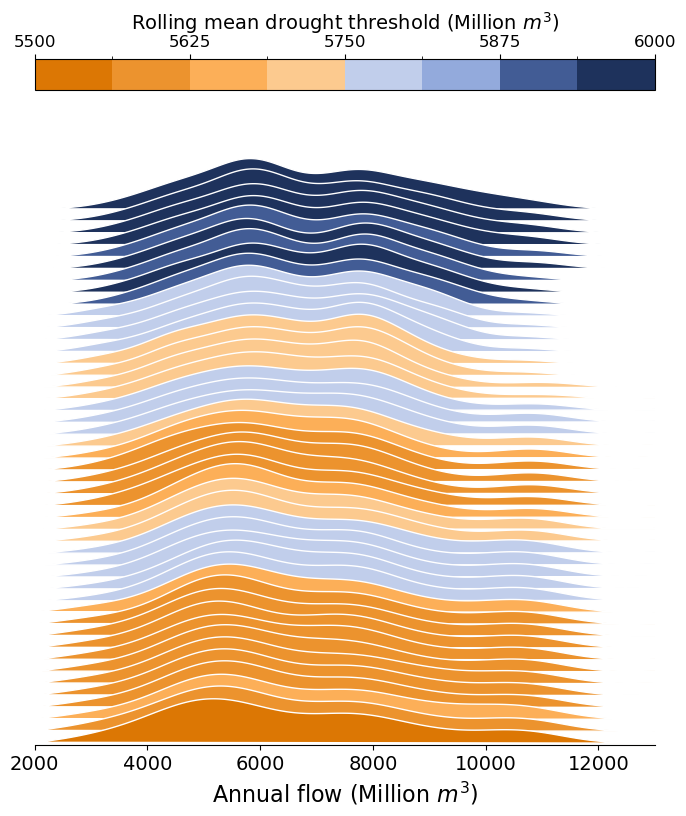

In [7]:
# Plot the progression of histograms to kernels
X = annual_historic_flows
X_plot = np.linspace(2000, 14000, 1000)
bins = np.linspace(2000, 14000, 10)
gs = (grid_spec.GridSpec(len(moving_windows),1))

fig = plt.figure(figsize=(8,10))

i = 0

#creating empty list
ax_objs = []

window_means = np.mean(moving_windows, axis=1)
st_deviations = np.std(moving_windows, axis=1)
drought_thresholds = window_means-0.5*st_deviations
cmap = mpl.colors.ListedColormap(['#dc7704', '#EC932E', '#fcaf58', '#fcca8f', '#c1ceeb', '#93aadc', '#425c95', '#1e325c'])
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(5500, 6000, 9)
normalize = mpl.colors.BoundaryNorm(bounds, cmap.N)
spines = ["top","right","left","bottom"]

for window in moving_windows:
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    kde_sp = gaussian_kde(window, bw_method=0.3)
    y_sp = kde_sp.pdf(X_plot)
    ax_objs[-1].fill(X_plot, y_sp, fc=cmap(normalize(drought_thresholds[i])), alpha = 1, edgecolor='white')

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(2000, 13000)
    ax_objs[-1].set_ylim(0, 0.0005)
    
    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_ylabel('')

    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
        
    if i == len(moving_windows)-1:
        ax_objs[-1].tick_params(axis='x', labelsize=14)
        ax_objs[-1].set_xlabel("Annual flow (Million $m^3$)", fontsize=16)
        ax_objs[-1].spines["bottom"].set_visible(True)
    else:
        ax_objs[-1].set_xticks([])
        ax_objs[-1].set_xticklabels([])
    
    ax_objs[-1].set_yticks([])

    i += 1

gs.update(hspace=-0.9)

# assign cmap and norm
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax_objs, location='top', ticks=np.linspace(5500, 6000, 5), pad=0)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Rolling mean drought threshold (Million $m^3$)', fontsize=14)
plt.savefig('rolling_window_thresholds.svg')
plt.show()

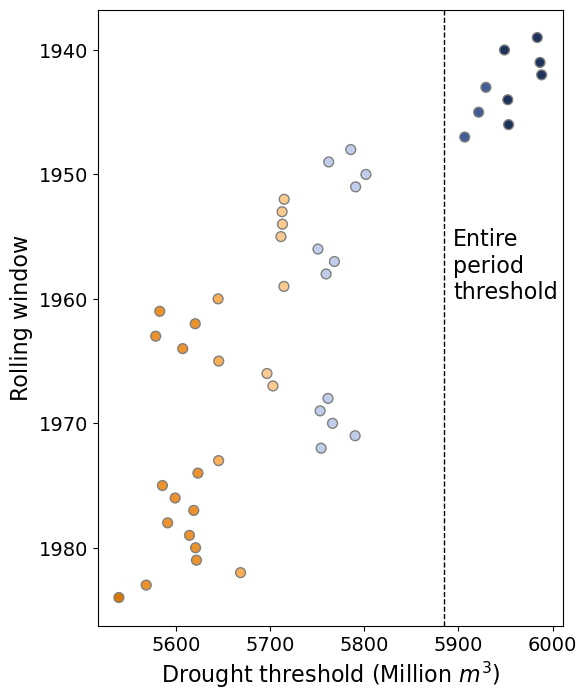

In [8]:
mean_flow = np.mean(annual_historic_flows)
st_deviation = np.std(annual_historic_flows)
drought_threshold = mean_flow-0.5*st_deviation

years = np.arange(1909+(window_size/2), 1909+(window_size/2)+(106-window_size))
plt.figure(figsize=(6,8))
plt.scatter(drought_thresholds, years, s=50, c=cmap(normalize(drought_thresholds)), edgecolor = 'grey')
plt.axvline(x=drought_threshold, color='k', linewidth=1, linestyle = '--')
plt.text(drought_threshold+10, 1960, "Entire\nperiod\nthreshold", fontsize=16)
plt.ylabel("Rolling window", fontsize = 16)
plt.xlabel("Drought threshold (Million $m^3$)", fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.gca().invert_yaxis()
plt.savefig('rolling_window_thresholds_scatter.svg')
plt.show()

In [9]:
np.min(drought_thresholds)

5539.63373421055

Percent of years crossing the threshold in each realization

In [10]:
drought_thresholds[-1]

5539.63373421055

Define function to estimate number of years in decadal drought

In [11]:
def drought_identification_values_only(timeseries, drought_threshold, decadal_window=11):   
    all_years = len(timeseries)
    
    window_size = decadal_window
    #Calculate rolling means for each drought window
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array to consider
    # every window of size 3
    while i < len(timeseries) - window_size + 1:
        # Store elements from i to i+window_size
        # in list to get the current window
        window = timeseries[i : i + window_size]

        # Calculate the average of current window
        window_average = round(sum(window) / window_size, 2)

        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1

    #Plot results
    half_window = math.floor(window_size/2)

    highlight_years=np.arange(half_window, all_years-half_window)[moving_averages < drought_threshold]
    all_drought_years_in_window = []
    for year in highlight_years:
        first_year = year-half_window
        last_year = year+half_window
        all_drought_years_in_window.extend(np.arange(first_year, last_year+1))

    all_drought_years = list(set(all_drought_years_in_window))
    
    return len(all_drought_years)

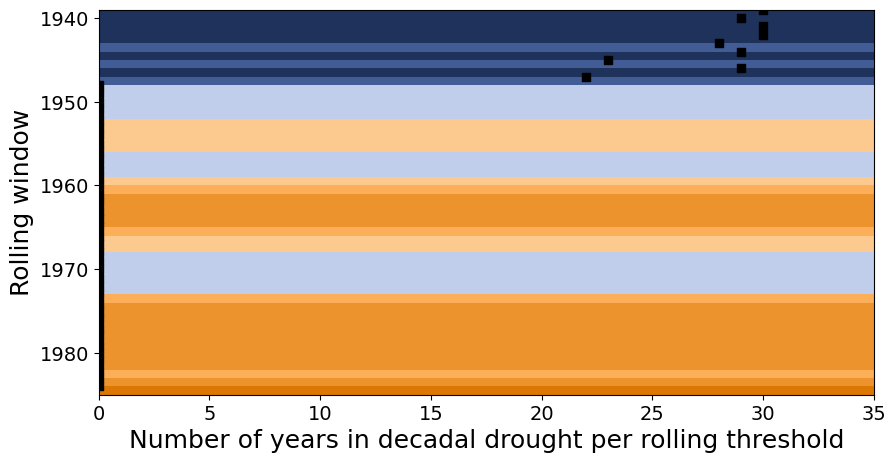

In [12]:
dataset_names = ["Historical"]

plt.figure(figsize=(10,5))

for x in range(len(years)):
    plt.axhspan(years[x], years[x]+1, facecolor=cmap(normalize(drought_thresholds[x])), alpha=1)

# percents = [np.around((annual_historic_flows <= x).sum(axis=0)/(len(annual_historic_flows))*100, decimals=0) 
#                  for x in drought_thresholds]
violations = [drought_identification_values_only(annual_historic_flows, x) 
                 for x in drought_thresholds]
plt.scatter(violations, years, marker = 's', color = 'black', zorder=100)
# plt.xticks(np.arange(0, 100, 10))
# plt.yticks(np.arange(1940, 2020,20))
plt.gca().invert_yaxis()
    
plt.xlabel("Number of years in decadal drought per rolling threshold", fontsize=18)
plt.ylabel("Rolling window", fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)


# Defining custom 'xlim' and 'ylim' values.
plt.xlim(0, 35)
plt.ylim(1985, 1939)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('years_below_threshold.svg', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
max(violations)

30

# Identify thresholds for persistence and variability across each streamflow window

In [16]:
import statsmodels.api as sm
import scipy.stats as ss
from fitHMM import fitHMM, makePPandQQplot
from matplotlib.patches import Rectangle

In [50]:
# fit HMM to true observations of flows at state line over historical record
def fitParams(flows):
    # create matrices to store the parameters
    # columns are mu0, sigma0, mu1, sigma1, p00, p11
    params = np.zeros([6])
    hidden_states, mus, sigmas, P, logProb = fitHMM(np.log(flows))
    
    params[0] = mus[0,0]
    params[1] = sigmas[0,0]
    params[2] = mus[1,0]
    params[3] = sigmas[1,0]
    params[4] = P[0,0]
    params[5] = P[1,1]
        
    return params

#Parameter values as estimated for last 70 years by Quinn et al. (2020), given in Table 1 
trueParams = np.array([[15.25811235, 0.2590614, 15.66100725, 0.25217403, 0.67910715, 0.64916877]]) 
trueParams = pd.DataFrame({'mu0':trueParams[:,0],'sigma0':trueParams[:,1],\
                           'mu1':trueParams[:,2],'sigma1':trueParams[:,3],\
                           'p00':trueParams[:,4],'p11':trueParams[:,5]})
trueParams['Ensemble'] = 'Observations'

In [51]:
#fit HMM over each rolling window 
simParams = np.zeros([len(moving_windows), 6])
for j in range(len(moving_windows)):
    simParams[j,:] = fitParams(moving_windows[j]/1233.4818*1000000)

In [52]:
print("The mean multiplier varies between {} and {}".format(np.min(simParams[:,0])/15.25811235, 
                                                            np.max(simParams[:,0])/15.25811235))

The mean multiplier varies between 0.9971040308630414 and 1.0136672054289129


In [53]:
print("The sigma multiplier varies between {} and {}".format(np.min(simParams[:,1])/0.2590614, 
                                                            np.max(simParams[:,1])/0.2590614))

The sigma multiplier varies between 0.4103764965017345 and 1.3767248971671517


In [54]:
LH_sample = pd.read_csv('../streamflow_data/LHsamples_wider_100_AnnQonly.txt',delimiter='\t')

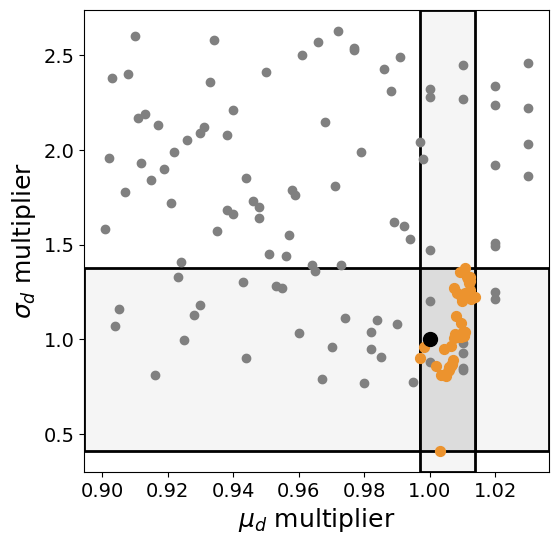

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(simParams[:,0]/15.25811235, simParams[:,1]/0.2590614, s=50, c='#EC932E', zorder=3)
ax.scatter(LH_sample['mu_dry'], LH_sample['sigma_dry'], color = 'grey', zorder=2)
ax.scatter(1, 1, color='black', s=100, zorder=4)
ax.set_xlabel("$\mu_d$ multiplier", fontsize=18)
ax.set_ylabel("$\sigma_d$ multiplier", fontsize=18)

ymin = np.min(simParams[:,1])/0.2590614
ymax = np.max(simParams[:,1])/0.2590614
xmin = np.min(simParams[:,0])/15.25811235
xmax = np.max(simParams[:,0])/15.25811235
# ax.axvline(xmin, linewidth=2, color='black')
# ax.axvline(xmax, linewidth=2, color='black')
# ax.axhline(ymin, linewidth=2, color='black')
# ax.axhline(ymax, linewidth=2, color='black')

ax.axhspan(ymin, ymax, facecolor='whitesmoke', edgecolor = 'black', linewidth=2, zorder=1)
ax.axvspan(xmin, xmax, facecolor='whitesmoke', edgecolor = 'black', linewidth=2, zorder=1)

# Create a Rectangle patch
rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                 edgecolor = 'black', linewidth=2, facecolor='gainsboro', zorder=1)

# Add the patch to the Axes
ax.add_patch(rect)


plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig('classification_thresholds.svg', dpi=300, bbox_inches='tight')
plt.show()

## Compare streamflow distributions across experiments

In [56]:
# load data and convert acre-ft to Million m^3
wider_100 = np.load('../streamflow_data/LHsamples_wider_100_AnnQonly_flows.npy')*1233.48/1000000
CMIP = np.load('../streamflow_data/CMIPunscaled_SOWs_flows.npy')*1233.48/1000000
Paleo = np.load('../streamflow_data/Paleo_SOWs_flows.npy')*1233.48/1000000

# compute annual sums
data = [annual_historic_flows, 
        annual_stationary_flows.flatten(),
        np.sum(CMIP, axis=2).flatten(), 
        np.sum(Paleo, axis=2).flatten(), 
        np.sum(wider_100, axis=2).flatten()]

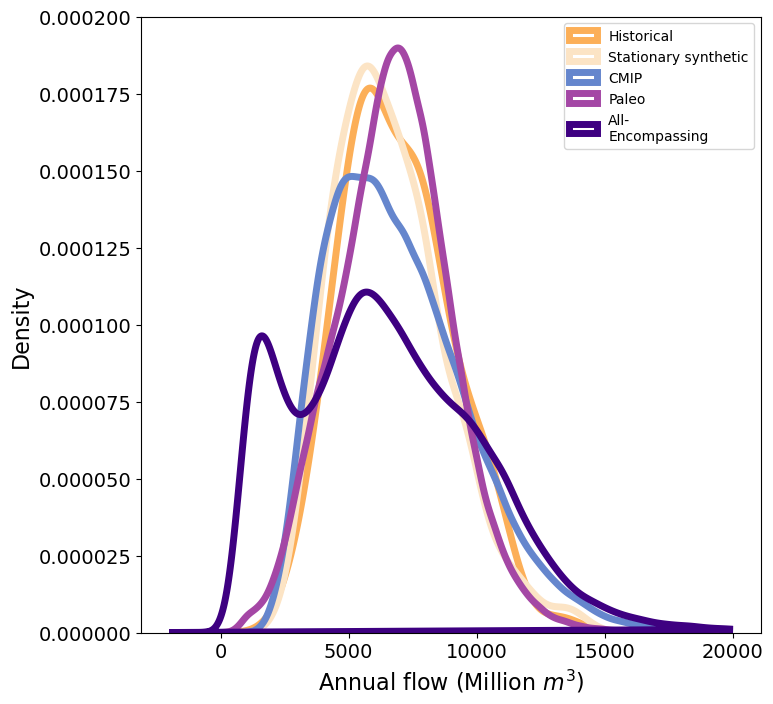

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

colors = ['#FCAF58', '#FCE4C5', '#6586CD', '#A447A5', '#3E0081']
labels=['Historical','Stationary synthetic','CMIP','Paleo','All-\nEncompassing']

X_plot = np.linspace(-2000, 20000, 1000)
bins = np.linspace(-2000, 20000, 1000)

for i in range(len(data)):
    # Plot the progression of histograms to kernels
    X = data[i]

    # Scipy KDE
    kde_sp = gaussian_kde(X)
    y_sp = kde_sp.pdf(X_plot)
    ax.fill(X_plot, y_sp, facecolor = "None", 
            edgecolor = colors[i], linewidth=5, label = labels[i])
# ax.set_xlim(5, 20000)
ax.set_ylim(0, 0.0002)
# ax.set_xscale('log')
ax.legend()
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel("Density", fontsize=16)
ax.set_xlabel("Annual flow (Million $m^3$)", fontsize=16)
plt.savefig('dataset_distributions.svg', dpi=300, bbox_inches='tight')